Macro-Statistics_Key_Indicators

In [1]:
"""Modules"""

import urllib.request, urllib.parse, urllib.error
import requests
from bs4 import BeautifulSoup

import lxml
import re
import os
import time
import datetime
import chardet
import zipfile
from zipfile import ZipFile
import json
from io import BytesIO

from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.transforms
%matplotlib inline

import folium
from PIL import Image


import numpy as np
import pandas as pd

pd.set_option('precision', 4)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('max_colwidth',100)

def curl(url,path,mode='wb'):
    response = urllib.request.urlopen(url).read()
    with open(path, mode) as handle:
        handle.write(response)

In [2]:
"""小写开头的字母用于临时变量"""

# data -- 用于创建表格的临时数据，创建完后必须赋值给永久变量
# df   -- 用于画图的临时数据，画图时将所需数据赋值给它
# dfs  -- 用于画图的临时数据字典，画图时将所需数据赋值给它
# domain
# 其他小写字母


"""初始化全局变量，请小心操作"""

# 用户自定义参数，会随着用户设置的变化而变化
D = ''    # Domain
A = ''    # Area     单一的国家/地区，
As = []
E = ''    # Element
Es = []
I = ''    # A paticular Item
Is = []   # Items

# 根据用户变量生成
DFs = {}        # 每个 Domain 的所有数据是一份 DF，keys=Domains，no index, columns=['Area Code', 'Area', 'Element', 'Item', 'Year', 'Unit', 'Value']
CDTs = {}       # 从DFs筛选数据的条件，key0=Domain, key1=Area, key2=Element, value=Items
PVs_AreaYear = {}        # 从DFs根据筛选条件生成的 DICT, key0=Domain, key1=Area, key2=Element, key3=Items, values=DF, index=Areas, columns=Years
PVs_YearArea = {}        # 从DFs根据筛选条件生成的 DICT, key0=Domain, key1=Area, key2=Element, key3=Items, values=DF, index=Years, columns=Areas

Years = []      # 年份列表

PVs_AG = {}     # 某国家地区与其所在组合的某些 Items 的比较，key0=Domain, key1=Area, key2=Element, key3=[AG, A, G], index=Years, columns=[C,G]

# 必要的信息 
DOMs = {}        # Domain 的描述字典， key=domain_name(file name's pref)
LIST_countries=[]  # 国家级地区列表，Area Code < 5000, default refer to  worlds contries
LIST_groups=[]    # 地区组合列表，Area Code >= 5000, default grouped by continents


""" DIRECTOR SETTINGS"""

FAO_DOWNLOADS_ROOT = 'http://fenixservices.fao.org/faostat/static/bulkdownloads/'
FAO_DOWNLOADS_XML = os.path.join(FAO_DOWNLOADS_ROOT, 'datasets_E.xml')
FAO_DOWNLOADS_JSON = os.path.join(FAO_DOWNLOADS_ROOT, 'datasets_E.json')
FAO_DOWNLOADS_BULK = os.path.join(FAO_DOWNLOADS_ROOT, 'FAOSTAT.zip')

print(f'FAOSTAT downloads root: {FAO_DOWNLOADS_ROOT}')
print(f'FAOSTAT description in .xml: {FAO_DOWNLOADS_XML}')
print(f'FAOSTAT description in .json: {FAO_DOWNLOADS_JSON}')
print(f'FAOSTAT downloads .zip: {FAO_DOWNLOADS_BULK}')

# what is the relevent path of root
root_where = '../../'
print('+++++++++ Atention ++++++++++')
print(f'The root is set as "{root_where}" relevent to this file.' )
print(f'If it is not right, you change this parameter where the parameter name is "root_where".' )
print('+++++++++++++++++++++++++++++')

LOCAL_ROOT = os.path.abspath(root_where)

DATA_BASE = os.path.join(LOCAL_ROOT, 'data')
DATA_FAO = os.path.join(DATA_BASE, 'FAO')
DATA_NBS = os.path.join(DATA_BASE, 'NBS')
DATA_hybrids = os.path.join(DATA_BASE, 'hybrids')

FAO_meta = os.path.join(DATA_FAO, 'metadata')
FAO_description_path = FAO_meta + '/datasets_E.xml'
FAO_BULK_zip = DATA_FAO + '/FAOSTAT.zip'

print(f'Root director: {LOCAL_ROOT}')
print(f'Data director: {DATA_BASE}')
print(f'FAO data director: {DATA_FAO}')
print(f'NBS data director: {DATA_NBS}')
print(f'Datasets hybrids director: {DATA_hybrids}')
print(f'FAO metadata director: {FAO_meta}')
print(f'FAO local description file: {FAO_description_path}')
print(f'FAO local datasets zip: {FAO_BULK_zip}')

SUFFIX = '_E_All_Data_(Normalized)'  # suffix of fao data file name
print(f'Suffix of raw FAO data file name: {SUFFIX}')

FAOSTAT downloads root: http://fenixservices.fao.org/faostat/static/bulkdownloads/
FAOSTAT description in .xml: http://fenixservices.fao.org/faostat/static/bulkdownloads/datasets_E.xml
FAOSTAT description in .json: http://fenixservices.fao.org/faostat/static/bulkdownloads/datasets_E.json
FAOSTAT downloads .zip: http://fenixservices.fao.org/faostat/static/bulkdownloads/FAOSTAT.zip
+++++++++ Atention ++++++++++
The root is set as "../../" relevent to this file.
If it is not right, you change this parameter where the parameter name is "root_where".
+++++++++++++++++++++++++++++
Root director: /mnt/sda2/_hub/projects/GoodFood/meat-atlas
Data director: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/data
FAO data director: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/data/FAO
NBS data director: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/data/NBS
Datasets hybrids director: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/data/hybrids
FAO metadata director: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/

In [3]:
def FAO_description_dic(soup):
    """
    input soup parsed by bs4
    parse it to dict with nessesary info
    """
    dic = {}
    for dataset in soup.find_all('Dataset'):
        file_loc = dataset.FileLocation.string
        domain = file_loc[file_loc.find('bulkdownloads/')+len('bulkdownloads/'):file_loc.find('_E_All')]
        dic[domain] = {'DatasetCode': dataset.DatasetCode.string,
                        'DatasetName': dataset.DatasetName.string,
                        'Topic': dataset.Topic.string,
                        'DatasetDescription': dataset.DatasetDescription.string,
                        'MedaData': [dataset.Contact.string, dataset.Email.string, dataset.DateUpdate.string, dataset.CompressionFormat.string, dataset.FileType.string, dataset.FileSize.string, dataset.FileRows.string],
                        'Url_Normalized':dataset.FileLocation.string}
    return dic

In [4]:
""" If you need to update, uncomment this cell. """
# # Download or update FAOSTAT datasets if necessary
# if os.path.exists(FAO_description_path) or os.path.exists(FAO_BULK_zip): pass
# else: 
#     print('Need to download or update FAOSTAT datasets.')
#     print('Processing ...')
#     curl(url=FAO_DOWNLOADS_XML, path=FAO_description_path)
#     curl(url=FAO_DOWNLOADS_BULK, path=FAO_BULK_zip)
    
# # Check local datasets update  
# print('Checking updates ...')

# # local datasets
# print('Checking Local description ...')
# with open(FAO_description_path, 'rb') as handle:
#     xml = handle.read()
#     soup = BeautifulSoup(xml, 'xml')
# xml_local = FAO_description_dic(soup)

# # online datasets
# print('Checking latest description ...')
# response = requests.get(FAO_DOWNLOADS_XML)
# xml = response.content
# soup = BeautifulSoup(xml, 'xml')
# xml_online = FAO_description_dic(soup)

# # compare
# print('Comparing ...')
# shared_items = {k: xml_local[k] for k in xml_local if k in xml_online and xml_local[k] == xml_online[k]}
# need_update = {k: xml_local[k] for k in xml_local if xml_local[k] != xml_online[k]}
# update_to = {k: xml_local[k] for k in xml_local if xml_local[k] != xml_online[k]}

# print('No. of local datasets: ', len(xml_local))
# print('No. of latest datasets: ', len(xml_online))
# print('No. of shared datasets: ', len(shared_items))

# if len(xml_local)==len(shared_items) and len(xml_local)==len(xml_online):
#     print ('Already up to date.')
# else:
#     print('Need update: ', need_update)
#     print('Update to: ', update_to)
#     print("NOTE: If you don't concern about datasets listed above, there's no need to update!")
    
# print('Done succesfully.')

' If you need to update, uncomment this cell. '

In [5]:
with open(FAO_description_path, 'rb') as handle:
    xml = handle.read()
    soup = BeautifulSoup(xml, 'xml')
DOMs = FAO_description_dic(soup)
# display(DOMs)

# 加载国家列表
LIST_countries = []
with open(FAO_meta+'/list_countries_world.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_countries.append(line)
LIST_countries.remove('China')  # Because we use `China, mainland`
print(f'There are {len(LIST_countries)} countries.')
# display(LIST_countries)

# 加载区域/组合列表
LIST_groups = []
with open(FAO_meta+'/list_groups_world.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_groups.append(line)
COUNT_groups = len(LIST_groups)
print(f'There are {len(LIST_groups)} groups.')
# display(LIST_groups)

# 自定义常用区域/组合列表
# OECD
LIST_countries_OECD = []
with open(FAO_meta+'/list_countries_OECD.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_countries_OECD.append(line)
print(f'There are {len(LIST_countries_OECD)} OECD countries.')
# display(LIST_countries_OECD)

# Asia
LIST_countries_asia = []
with open(FAO_meta+'/list_countries_asia.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_countries_asia.append(line)
print(f'There are {len(LIST_countries_asia)} Asian countries.')
# display(LIST_countries_asia)

There are 225 countries.
There are 34 groups.
There are 36 OECD countries.
There are 53 Asian countries.


In [44]:
# plt.style.use(['ggplot'])

# fig size
FIG_size = (6, 3)
DPI = 300

# font size
TIT_size = 12    # titles
LAB_size = 10    # labels
LEG_size = 10    # legends
TCK_size = 10    # ticklabels

LIN_wei = 1.5    # line weights
BAR_wid = 3      # bar width

# GRD_wid = 0.5    # grid line width
# GRD_clr = 'white' 
# GRD_aph = 1     # grid alpha

CLs = ('#ffab91','#c62828','#689f38','#ff6f00','#8c9eff','#ffc400','#283593',
       'chocolate','r','orange','maroon','hotpink','b','yellowgreen','deepskyblue','g','c','lightslategray','k')

CLs_2 = ("#f57f17", "#b2dfdb")

MKs = ('o', 'x','o','x', 'v','.','v','.','o','x','o', 'x', 'v','.','v','.')
LSs = ('-','-','--', ':', ':','-.','-.','-','-','--','--', ':', ':','-.','-.')

# =============================================================================================================
def setX_quant(ax, ticks, step, label = ''):
    ax.set_xticks(ticks)
    ax.set_xlim(ticks[0]-step/2,ticks[-1]+step/2)
    ax.set_xticklabels(ticks, rotation=0, ha='center', fontsize=TCK_size)
    ax.set_xlabel(label, fontsize=LAB_size)
#     ax.xaxis.grid(True, linewidth=GRD_wid, color=GRD_clr, alpha=GRD_aph)
    
def setX_quali(ax, ticks, label = ''):
    ax.set_xticklabels(ticks, rotation=90, ha='center', fontsize=TCK_size)
    ax.set_xlabel(label, fontsize=LAB_size)
#     ax.xaxis.grid(True, linewidth=GRD_wid, color=GRD_clr, alpha=GRD_aph)

def setY_quant(ax, y_max, label = ''):
    tick_num = 9
    step = y_max/(tick_num-1)
    min_gap = 10
    
    if step < 1:
        step = round(step,1)
        dec=1
    elif step < 10:
        step = int(step)
        dec=0
    elif step/min_gap < 10:
        step = int(step/min_gap)*10
        dec=0
    else:
        n=0
        while step/min_gap >= 10:
            step = int(step/min_gap)
            n += 1
        step = int(step/min_gap)*(min_gap**(n+1))
        dec=0
        
    y_max = step*(tick_num+1)        
    ticks = np.round(np.arange(0, y_max+step, step),decimals=dec)
    ax.set_yticks(ticks)
    ax.set_ylim(ticks[0],ticks[-1]+step)
    ax.set_yticklabels(ticks, fontsize=TCK_size)
    ax.set_ylabel(label, fontsize=LAB_size) 
#     ax.yaxis.grid(True, linewidth=GRD_wid, color=GRD_clr, alpha=GRD_aph)
    
def setY_per(ax):
    ticks=np.round(np.linspace(0, 100, num=11, endpoint=True), decimals=0)
    ax.set_yticks(ticks)
    ax.set_ylim(ticks[0],ticks[-1])
    ax.set_yticklabels(ticks, fontsize=TCK_size)
    ax.set_ylabel('Percentage (%)', fontsize=LAB_size)
#     ax.yaxis.grid(True, linewidth=GRD_wid, color=GRD_clr, alpha=GRD_aph)

In [7]:
def rdDF(domain):
    
    display(DOMs[domain])
    
    zf = ZipFile(f'{DATA_FAO}/{domain}{SUFFIX}.zip')
    encodings = ["ISO-8859-1", "UTF-8", "UTF-8-SIG", "GBK"]
    for encoding in encodings:
        try:
            data = pd.read_csv(zf.open(f'{domain}{SUFFIX}.csv'), encoding="ISO-8859-1")
        except:
            pass
    
    display(data.head())
    display(data.tail())

    return data

## 某个国家的人口

In [8]:
# 给 Domain 赋值，查看数据基础信息
D = 'Macro-Statistics_Key_Indicators'

In [9]:
""" Check update information if you've run update cell before, and if the domain has been updated , uncomment this cell. """
# with ZipFile(FAO_BULK_zip, 'r') as zf1:
#     zf1.extract(f'{D}{SUFFIX}.zip', DATA_FAO)                 

" Check update information if you've run update cell before, and if the domain has been updated , uncomment this cell. "

In [10]:
# Show you raw data
DATA = rdDF(D)
print('data shape: ', DATA.shape)

{'DatasetCode': 'MK',
 'DatasetName': 'Macro-Statistics: Macro Indicators',
 'Topic': '*TE - Total Economy (ISIC Rev. 4, A-U_01-99),*AFF -Agriculture, Forestry, and Fishing (ISIC Rev. 4, A_01-03),*Ag - Agriculture or "Crop and animal production, hunting and related service activities" (ISIC Rev. 4, A_01),*MAN - Manufacturing (ISIC Rev. 4, C_10-33),*FBT - Manufacture of food products, beverages and tobacco products(ISIC Rev. 4, C_10-12),*FB - Manufacture of food products and beverages (ISIC Rev. 4, C_10-11),*Tob - Manufacture of tobacco products (ISIC Rev. 4, C_12).',
 'DatasetDescription': "TheFAOSTAT Macro Indicatorsdatabase provides a selection of country-level macroeconomic indicators relating to total economy (TE); agriculture (Ag); agriculture, forestry and fishing (AFF); manufacturing (MAN); manufacturing of food products and beverages (FB); manufacturing of tobacco products (Tob); and manufacturing of food, beverage and tobacco products (FBT). It releases time series for a selec

/home/sheldon/anaconda3/envs/meat-atlas/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3242: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
0,2,Afghanistan,22008,Gross Domestic Product,6109,Value Local Currency,1970,1970,millions,78.6971,X,Data from UNSD AMA
1,2,Afghanistan,22008,Gross Domestic Product,6109,Value Local Currency,1971,1971,millions,82.3970,X,Data from UNSD AMA
2,2,Afghanistan,22008,Gross Domestic Product,6109,Value Local Currency,1972,1972,millions,71.7975,X,Data from UNSD AMA
3,2,Afghanistan,22008,Gross Domestic Product,6109,Value Local Currency,1973,1973,millions,77.9973,X,Data from UNSD AMA
4,2,Afghanistan,22008,Gross Domestic Product,6109,Value Local Currency,1974,1974,millions,96.9966,X,Data from UNSD AMA


,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
722105,5817,Net Food Importing Developing Countries,22039,Gross National Income per capita,6119,Value US$,2013,2013,NaN,1775.3407,Fc,NaN
722106,5817,Net Food Importing Developing Countries,22039,Gross National Income per capita,6119,Value US$,2014,2014,NaN,1850.8501,Fc,NaN
722107,5817,Net Food Importing Developing Countries,22039,Gross National Income per capita,6119,Value US$,2015,2015,NaN,1796.5353,Fc,NaN
722108,5817,Net Food Importing Developing Countries,22039,Gross National Income per capita,6119,Value US$,2016,2016,NaN,1729.7437,Fc,NaN
722109,5817,Net Food Importing Developing Countries,22039,Gross National Income per capita,6119,Value US$,2017,2017,NaN,1744.6762,Fc,NaN


data shape:  (722110, 12)


In [11]:
# 查看数据 Years 范围
Years = DATA['Year'].unique()
print(f'Dataset years range: {Years[0]} ~ {Years[-1]}')

# 定义 Years 分析范围
# Years = range(1961,2019+1)
print(f'You choose years range: {Years[0]} ~ {Years[-1]}')

DATA = DATA[DATA['Year'].isin(Years)]

Dataset years range: 1970 ~ 2017
You choose years range: 1970 ~ 2017


In [12]:
# 选择列
COLUMNS = ['Area Code', 'Area', 'Element', 'Item', 'Year', 'Unit', 'Value']

DATA = DATA[COLUMNS]
print('data shape: ', DATA.shape)

# 去空值和重复值（不是必须的，检查 data shape）
DATA = DATA.dropna().drop_duplicates()
print('data shape after drop Non. and Dup.: ', DATA.shape)

# 查看数据构成
print('Groupe data by Elements and Items: ')
display(DATA.groupby(['Element','Item']).count())

data shape:  (722110, 7)
data shape after drop Non. and Dup.:  (679324, 7)
Groupe data by Elements and Items: 


Area Code  \
Element                                    Item                                                                           
Annual growth Local Currency               Gross Domestic Product                                                  9394   
                                           Gross Fixed Capital Formation                                           9347   
                                           Gross Output (Agriculture)                                              1810   
                                           Gross Output (Agriculture, Forestry and Fishing)                        2585   
                                           Value Added (Agriculture)                                               1938   
                                           Value Added (Agriculture, Forestry and Fishing)                         9300   
                                           Value Added (Manufacture of food and beverages)                         1644   
                                           Value Added (Manufacture of food, beverages and tobacco products)       1759   
                                           Value Added (Manufacture of tobacco products)                           1326   
                                           Value Added (Total Manufacturing)                                       9351   
Annual growth US$                          Gross Domestic Product                                                 10970   
                                           Gross Domestic Product per capita                                      10970   
                                           Gross Fixed Capital Formation                                          10922   
                                           Gross National Income                                                  10972   
                                           Gross Output (Agriculture)                                              1810   
                                           Gross Output (Agriculture, Forestry and Fishing)                        2585   
                                           Value Added (Agriculture)                                               1938   
                                           Value Added (Agriculture, Forestry and Fishing)                        10876   
                                           Value Added (Manufacture of food and beverages)                         2390   
                                           Value Added (Manufacture of food, beverages and tobacco products)       2468   
                                           Value Added (Manufacture of tobacco products)                           2008   
                                           Value Added (Total Manufacturing)                                      10927   
Annual growth, Local Currency, 2010 prices Gross Domestic Product                                                  9256   
                                           Gross Fixed Capital Formation                                           9209   
                                           Value Added (Agriculture, Forestry and Fishing)                         9162   
                                           Value Added (Total Manufacturing)                                       9209   
Annual growth, US$, 2010 prices            Gross Domestic Product                                                 10972   
                                           Gross Domestic Product per capita                                      10972   
                                           Gross Fixed Capital Formation                                          10925   
                                           Value Added (Agriculture, Forestry and Fishing)                        10878   
                                           Value Added (Total Manufacturing)                                      10927   
Share of GDP in Local Currency             Gross Fi

In [13]:
# Countries available
Areas = DATA['Area'].unique()
Countries = [c for c in LIST_countries if c in Areas]
print('Chountries available in this domain:')
print(Countries)

Chountries available in this domain:
['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China, Hong Kong SAR', 'China, Macao SAR', 'China, mainland', 'Colombia', 'Comoros', 'Congo', 'Cook Islands', 'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Czechoslovakia', "Democratic People's Republic of Korea", 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Et

In [14]:
# Groupes available
Areas = DATA['Area'].unique()
Countries = [c for c in LIST_groups if c in Areas]
print('Chountries available in this domain:')
print(Countries)

Chountries available in this domain:
['World', 'Africa', 'Eastern Africa', 'Middle Africa', 'Northern Africa', 'Southern Africa', 'Western Africa', 'Americas', 'Northern America', 'Central America', 'Caribbean', 'South America', 'Asia', 'Central Asia', 'Eastern Asia', 'Southern Asia', 'South-Eastern Asia', 'Western Asia', 'Europe', 'Eastern Europe', 'Northern Europe', 'Southern Europe', 'Western Europe', 'Oceania', 'Australia and New Zealand', 'Melanesia', 'Micronesia', 'Polynesia', 'European Union', 'Least Developed Countries', 'Land Locked Developing Countries', 'Small Island Developing States', 'Low Income Food Deficit Countries', 'Net Food Importing Developing Countries']


# 中国

## 历年 GDP 总值

In [15]:
def DfCoutries(
    raw_data,
    element,
    item,
    countries_list=LIST_countries_OECD,
):
    """ 
    Computing OECD data frame
    """

    df = DATA.copy()

    # X Values
    X_step = 5
    X_ticks = range(1980, 2015+X_step, X_step)

    df = df[
        (df['Area'].isin(LIST_countries_OECD)) & 
        (df['Element']==element) & 
        (df['Item']==item) &
        (df['Year'].isin(X_ticks))
    ]
    df = df[['Year', 'Area', 'Value']]
    df.set_index(['Year'], inplace=True, drop=True)


    dfs = {}
    for c in LIST_countries_OECD:
        dfs[c] = df[(df['Area']==c)][['Value']]
        dfs[c].columns = [[c]]

    df_OECD = pd.DataFrame()
    for c in LIST_countries_OECD:
        df_OECD = pd.concat([df_OECD, dfs[c]], axis=1)

    df_OECD['Total'] = df_OECD.apply(lambda x: x.sum(), axis=1)
    df_OECD['Average'] = df_OECD[LIST_countries_OECD].mean(axis=1)

    display(df_OECD)
    
    return df_OECD
    

In [17]:
""" shortcut """

# DF_CN
data = DATA.copy()

E = 'Value US$, 2010 prices'
I = 'Gross Domestic Product'

X_step = 5
X_ticks = np.array(range(1980, 2015+X_step, X_step))
DF_CN = data[
    (data['Area']=='China, mainland') & 
    (data['Element']==E) & 
    (data['Item']==I) &
    (data['Year'].isin(X_ticks))
]

display('DF_CN: ', DF_CN)
print("")

# DF_OECD
display('DF_OECD: ')
DF_OECD = DfCoutries(
    raw_data=DATA,
    element=E,
    item=I,
    countries_list=LIST_countries_OECD,
)

'DF_CN: '

,Area Code,Area,Element,Item,Year,Unit,Value
131817,41,"China, mainland","Value US$, 2010 prices",Gross Domestic Product,1980,millions,3.4147e+05
131822,41,"China, mainland","Value US$, 2010 prices",Gross Domestic Product,1985,millions,5.6634e+05
131827,41,"China, mainland","Value US$, 2010 prices",Gross Domestic Product,1990,millions,8.2971e+05
131832,41,"China, mainland","Value US$, 2010 prices",Gross Domestic Product,1995,millions,1.4790e+06
131837,41,"China, mainland","Value US$, 2010 prices",Gross Domestic Product,2000,millions,2.2371e+06
131842,41,"China, mainland","Value US$, 2010 prices",Gross Domestic Product,2005,millions,3.5700e+06
131847,41,"China, mainland","Value US$, 2010 prices",Gross Domestic Product,2010,millions,6.1006e+06
131852,41,"China, mainland","Value US$, 2010 prices",Gross Domestic Product,2015,millions,8.9084e+06


'DF_OECD: '

,Australia,Austria,Belgium,Canada,Chile,Czechia,Denmark,Estonia,Finland,France,Germany,Greece,Hungary,Iceland,Ireland,Israel,Italy,Japan,Republic of Korea,Latvia,Lithuania,Luxembourg,Mexico,Netherlands,New Zealand,Norway,Poland,Portugal,Slovakia,Slovenia,Spain,Sweden,Switzerland,Turkey,United Kingdom,United States of America,Total,Average
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1980,4.9932e+05,208332.9056,270425.3708,7.8131e+05,58812.6071,NaN,186366.4691,NaN,122643.0291,1.4826e+06,2.0405e+06,184586.7305,93105.4927,6038.3742,58433.3540,65168.3431,1.3798e+06,3.0193e+06,1.4105e+05,NaN,NaN,15526.3796,5.3776e+05,430739.3775,70026.4418,198308.8205,233322.5800,120974.2386,NaN,NaN,6.5387e+05,258766.0404,346881.3717,2.1902e+05,1.2083e+06,6.4963e+06,2.1388e+07,7.1292e+05
1985,5.7730e+05,224100.8349,283437.8324,8.9099e+05,56647.1926,NaN,213346.5503,NaN,141128.0212,1.6042e+06,2.1836e+06,185845.6568,101586.9731,6768.8435,66270.3120,76059.1360,1.5000e+06,3.7007e+06,2.2057e+05,NaN,NaN,17554.0268,5.9194e+05,455443.3333,81515.0206,235050.6030,231200.7888,126435.7453,NaN,NaN,7.0075e+05,285573.2933,373821.0955,2.7772e+05,1.3584e+06,7.6418e+06,2.4410e+07,8.1366e+05
1990,6.7528e+05,260194.6248,329971.6882,1.0141e+06,78446.5096,144549.7650,229126.5675,15021.7803,167117.2023,1.8941e+06,2.5686e+06,197652.9439,104266.8237,7912.6342,83401.6276,94305.3500,1.7492e+06,4.7036e+06,3.6289e+05,25765.1546,33316.8816,25172.2814,6.4321e+05,536976.6222,82680.2469,255627.8854,226663.6037,166592.6052,51010.3913,30861.4319,8.7314e+05,321511.4222,432100.1205,3.6395e+05,1.6118e+06,9.0012e+06,2.9361e+07,8.1559e+05
1995,7.9135e+05,290414.1262,357103.1078,1.1028e+06,118979.1478,139035.6708,257078.3640,10493.9106,163433.9779,2.0195e+06,2.8410e+06,210286.4277,92506.4253,8017.0341,104603.8473,133128.2806,1.8662e+06,5.0638e+06,5.4361e+05,12741.5682,19320.6864,30555.6721,7.0743e+05,601443.6333,96533.6597,307138.0485,252409.3788,181278.7471,46643.3236,29973.0796,9.4094e+05,333105.3730,434925.0361,4.2626e+05,1.7711e+06,1.0217e+07,3.2522e+07,9.0339e+05
2000,9.5735e+05,336495.4753,411796.9745,1.3427e+06,145838.8425,151842.4463,298220.9519,14103.1928,209379.5867,2.3335e+06,3.1239e+06,251508.7024,107164.3030,10535.4719,163548.6779,170919.6539,2.0602e+06,5.3489e+06,7.1004e+05,16399.4887,24270.7257,40777.8741,9.1522e+05,743623.5149,111769.0504,366955.3998,326204.6894,221371.3063,55486.1097,36935.7217,1.1495e+06,397037.6546,487149.0982,5.2093e+05,2.0899e+06,1.2620e+07,3.8272e+07,1.0631e+06
2005,1.1316e+06,367272.6495,450521.4320,1.5245e+06,181652.3489,183918.1600,318622.8847,19901.6135,237927.5559,2.5368e+06,3.2138e+06,304330.9351,132407.4114,12947.9924,214525.7170,188895.0580,2.1587e+06,5.6723e+06,8.9471e+05,24315.5147,35021.7161,47158.0783,9.8274e+05,794651.1717,135951.7950,409135.1982,379768.5139,231123.6700,70976.2271,44069.3027,1.3581e+06,451912.8091,524104.1925,6.5811e+05,2.4034e+06,1.4332e+07,4.2628e+07,1.1841e+06
2010,1.2973e+06,391892.7465,483548.0312,1.6135e+06,218537.5655,207477.8579,321995.3504,19502.5550,247799.8158,2.6426e+06,3.4171e+06,299361.5766,130922.6387,13683.6897,222134.0460,233732.9278,2.1251e+06,5.7001e+06,1.0945e+06,23765.1687,37130.2862,53212.4768,1.0578e+06,846554.8949,146583.8315,429130.9527,479321.4606,238303.4434,89501.0129,48013.6067,1.4316e+06,488909.0787,583782.9779,7.7188e+05,2.4529e+06,1.4992e+07,4.4851e+07,1.2459e+06
2015,1.4931e+06,413554.5959,509186.0208,1.8025e+06,264555.2681,225492.7022,343294.4973,23341.2776,247409.1106,2.7813e+06,3.7185e+06,244718.5350,144235.9930,15682.2996,316886.8175,279246.8798,2.0624e+06,5.9964e+06,1.2688e+06,28256.8345,44693.1920,61081.6388,1.2231e+06,881473.9767,170509.4640,467661.3396,556360.8928,228052.0701,101627.6578,48978.4322,1.4210e+06,543060.9349,634044.5978,1.0878e+06,2.7196e+06,1.6710e+07,4.9078e+07,1.3633e+06


In [24]:
def PopulationInAnArea(
    raw_data, 
    area, 
    unit = 'Billion US$',
    element='Value US$, 2010 prices',
    item='Gross Domestic Product',
):
    
    df = raw_data.copy()
    print("The shape and the head of the raw data.")
    print(df.shape)
    display(df.head())
    
    # X values
    X_step = 5
    X_ticks = range(1980, 2015+X_step, X_step)

    df = df[
        (df['Area']==area) & 
        (df['Element']==element) & 
        (df['Item']==item) &
        (df['Year'].isin(X_ticks))
    ]

    title = f"Total Gross Domestic Product in {area}"
    if unit == '': 
        sub_title = f"Unit: {element}, Million"
    elif unit == 'Billion US$':
        df['Unit'] = unit
        df['Value'] = df['Value']/1000
        sub_title = f"Unit: {element}, Billion"
        
    print("The shape and the head of the data after selecting.")
    print(df.shape)
    display(df.head())

    fig = plt.figure(figsize = FIG_size, dpi=DPI)
    plt.suptitle(title, fontsize=TIT_size, y=1.03)
    plt.title(sub_title, fontsize=TIT_size-1)

    # Plot Y values
    plt.bar(X_ticks, np.array(df['Value']), width=BAR_wid, color=CLs_2[0])

    ax = plt.gca()

    # Notation
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate('{:.0f}'.format(height), (x, y+height+100), fontsize=LEG_size)
        
    setX_quant(ax, X_ticks, X_step)

    plt.yticks([])

    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

The shape and the head of the raw data.
(679324, 7)


,Area Code,Area,Element,Item,Year,Unit,Value
0,2,Afghanistan,Value Local Currency,Gross Domestic Product,1970,millions,78.6971
1,2,Afghanistan,Value Local Currency,Gross Domestic Product,1971,millions,82.3970
2,2,Afghanistan,Value Local Currency,Gross Domestic Product,1972,millions,71.7975
3,2,Afghanistan,Value Local Currency,Gross Domestic Product,1973,millions,77.9973
4,2,Afghanistan,Value Local Currency,Gross Domestic Product,1974,millions,96.9966


The shape and the head of the data after selecting.
(8, 7)


,Area Code,Area,Element,Item,Year,Unit,Value
131817,41,"China, mainland","Value US$, 2010 prices",Gross Domestic Product,1980,Billion US$,341.4707
131822,41,"China, mainland","Value US$, 2010 prices",Gross Domestic Product,1985,Billion US$,566.3415
131827,41,"China, mainland","Value US$, 2010 prices",Gross Domestic Product,1990,Billion US$,829.7053
131832,41,"China, mainland","Value US$, 2010 prices",Gross Domestic Product,1995,Billion US$,1479.0357
131837,41,"China, mainland","Value US$, 2010 prices",Gross Domestic Product,2000,Billion US$,2237.1212


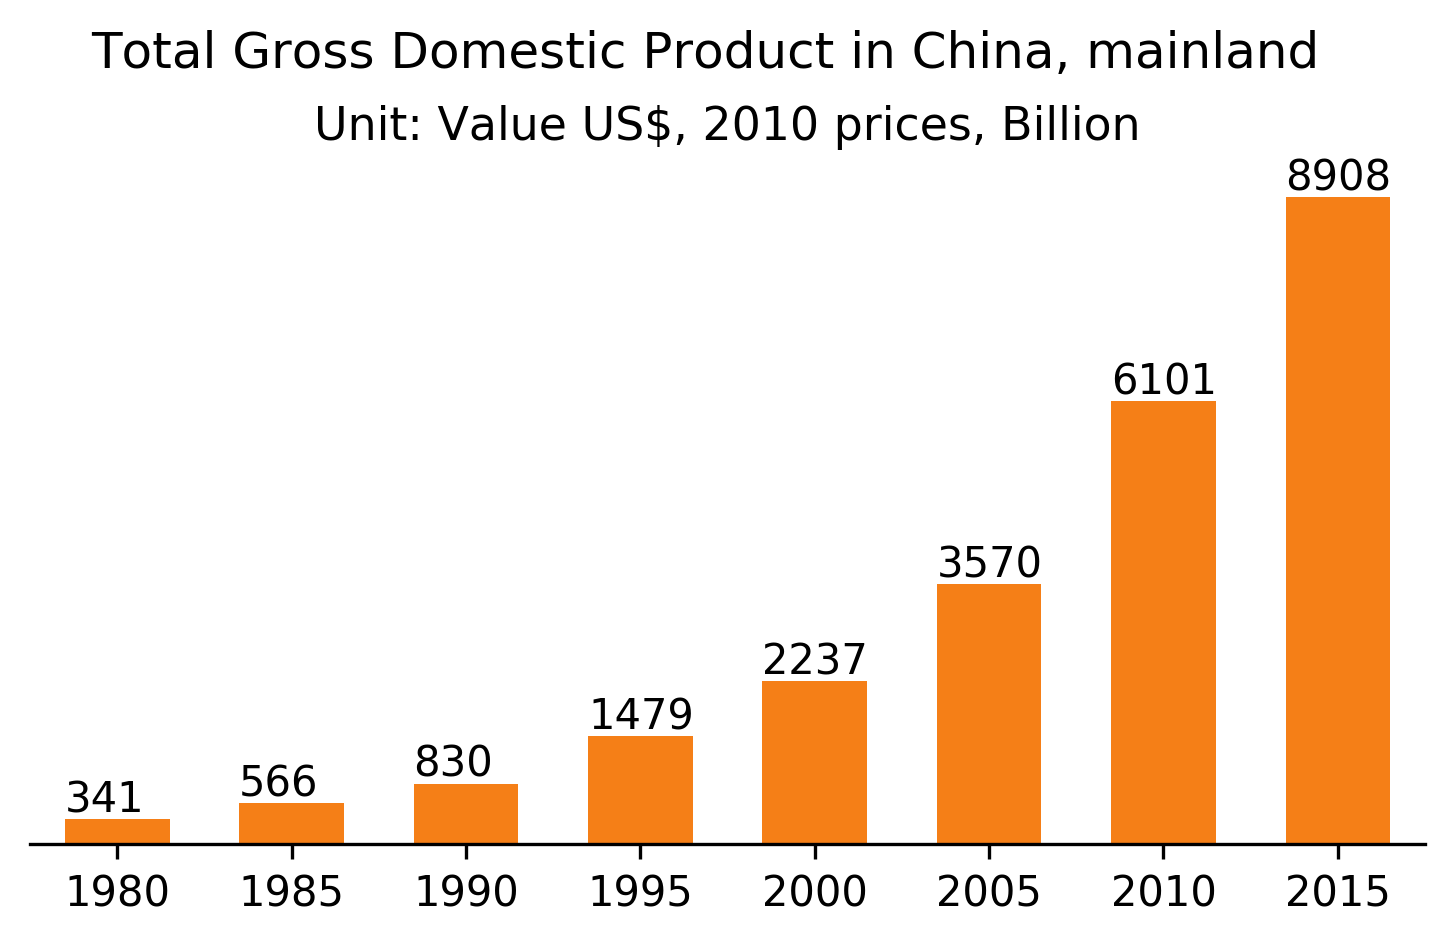

In [25]:
PopulationInAnArea(
    raw_data=DATA, 
    area='China, mainland', 
    unit ='Billion US$',
)

## GDP 总量占世界的比重

In [40]:
def AsPercentageOfWorld(
    raw_data,
    area,
    element = 'Total Population - Both sexes',
    item = 'Population - Est. & Proj.',
):
    df = raw_data.copy()

    # X Values
    X_step = 5
    X_ticks = range(1980, 2015+X_step, X_step)

    df_c = df[
        (df['Area']==area) & 
        (df['Element']==element) & 
        (df['Item']==item) &
        (df['Year'].isin(X_ticks))
    ]
    df_c = df_c[['Year', 'Value']]
    df_c.set_index(['Year'], inplace=True, drop=True)
    display(df_c)

    df_w = df[
        (df['Area']=='World') & 
        (df['Element']==element) & 
        (df['Item']==item) &
        (df['Year'].isin(X_ticks))
    ]
    df_w = df_w[['Year', 'Value']]
    df_w.set_index(['Year'], inplace=True, drop=True)
    display(df_w)

    df_compare = pd.concat([df_c, df_w], axis=1, names=['Year'])
    df_compare.columns = [area, 'World']
    df_compare['Others'] = df_compare['World'] - df_compare[area]
    df_compare['As a percentage of the world'] = df_compare[area] / df_compare['World']

    display(df_compare)

    title = f"Total GDP as a percentage of the world in {area}"

    fig = plt.figure(figsize = FIG_size, dpi=DPI)
    plt.suptitle(title, fontsize=TIT_size, y=1.05)

    # Plot
    plt.bar(X_ticks, np.array(df_compare['As a percentage of the world']), width=BAR_wid, color=CLs_2[0])

    ax = plt.gca()

    # Notation
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate('{:.1%}'.format(height), (x, y+height+0.01), fontsize=LEG_size)

    plt.bar(X_ticks, np.ones(len(X_ticks),np.int), width=BAR_wid, color="#666666", alpha=0.1)

    plt.yticks([])

    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

,Value
Year,
1980,3.4147e+05
1985,5.6634e+05
1990,8.2971e+05
1995,1.4790e+06
2000,2.2371e+06
2005,3.5700e+06
2010,6.1006e+06
2015,8.9084e+06


,Value
Year,
1980,2.7867e+07
1985,3.1727e+07
1990,3.7874e+07
1995,4.2026e+07
2000,4.9777e+07
2005,5.7900e+07
2010,6.5703e+07
2015,7.5333e+07


,"China, mainland",World,Others,As a percentage of the world
Year,,,,
1980,3.4147e+05,2.7867e+07,2.7525e+07,0.0123
1985,5.6634e+05,3.1727e+07,3.1161e+07,0.0179
1990,8.2971e+05,3.7874e+07,3.7045e+07,0.0219
1995,1.4790e+06,4.2026e+07,4.0547e+07,0.0352
2000,2.2371e+06,4.9777e+07,4.7540e+07,0.0449
2005,3.5700e+06,5.7900e+07,5.4330e+07,0.0617
2010,6.1006e+06,6.5703e+07,5.9603e+07,0.0929
2015,8.9084e+06,7.5333e+07,6.6425e+07,0.1183


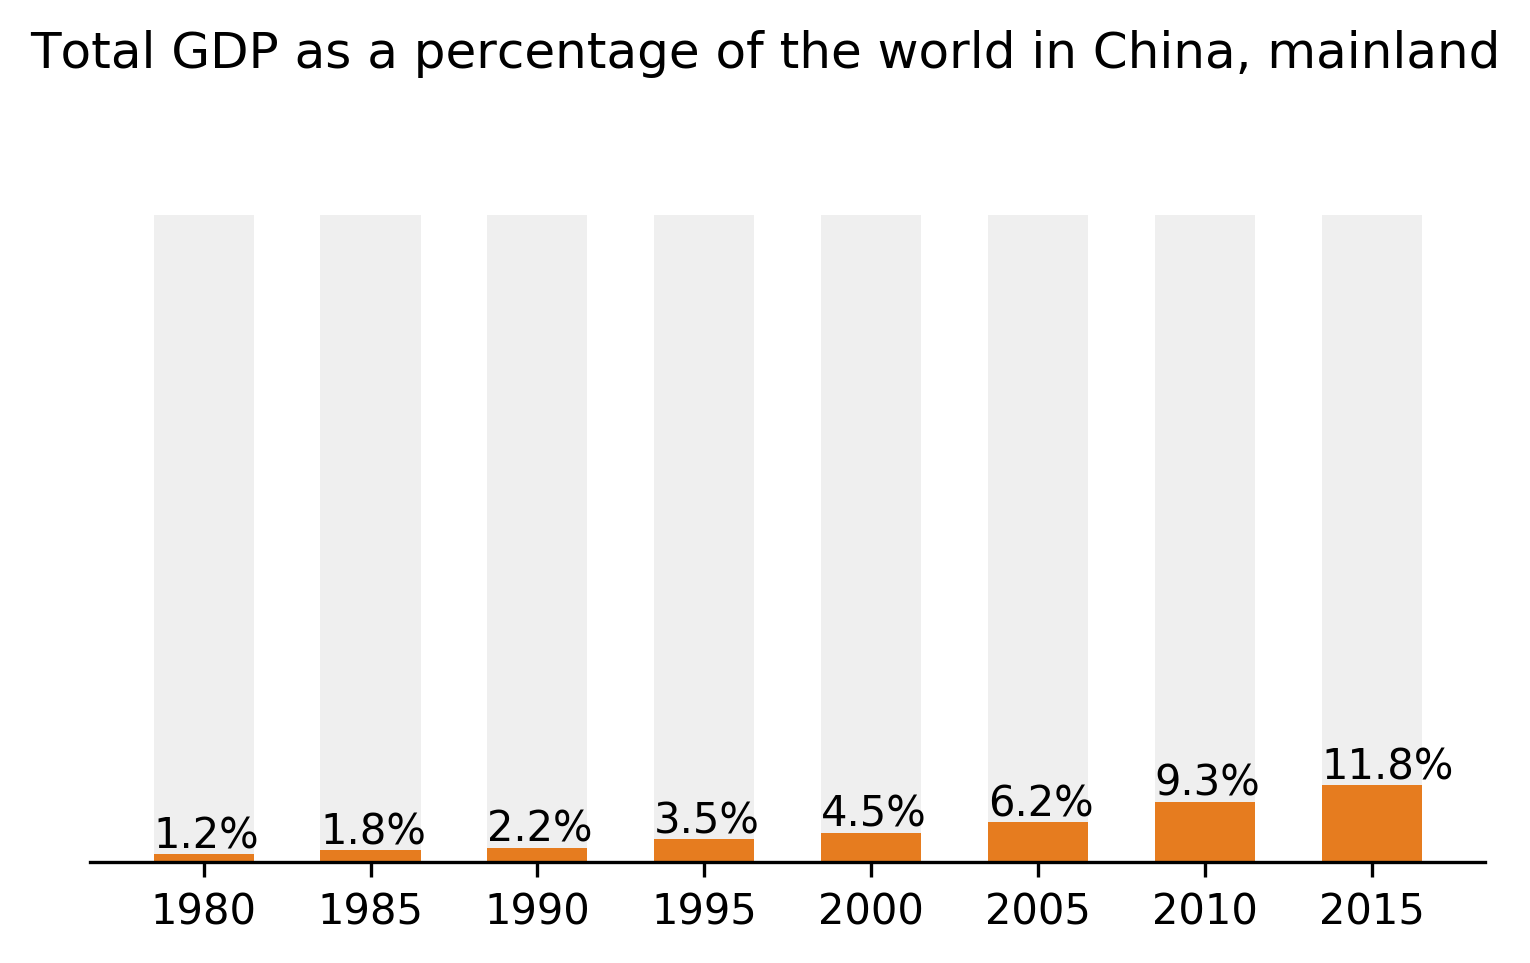

In [41]:
AsPercentageOfWorld(
    raw_data=DATA,
    area='China, mainland',
    element ='Value US$, 2010 prices',
    item ='Gross Domestic Product',
)

## 对比世界经合组织

,"China, mainland",OECD Total
Year,,
1980,341.4707,21387.7126
1985,566.3415,24409.8940
1990,829.7053,29361.3059
1995,1479.0357,32521.9970
2000,2237.1212,38271.8175
2005,3569.9984,42628.3647
2010,6100.6483,44851.1259
2015,8908.4346,49078.3524


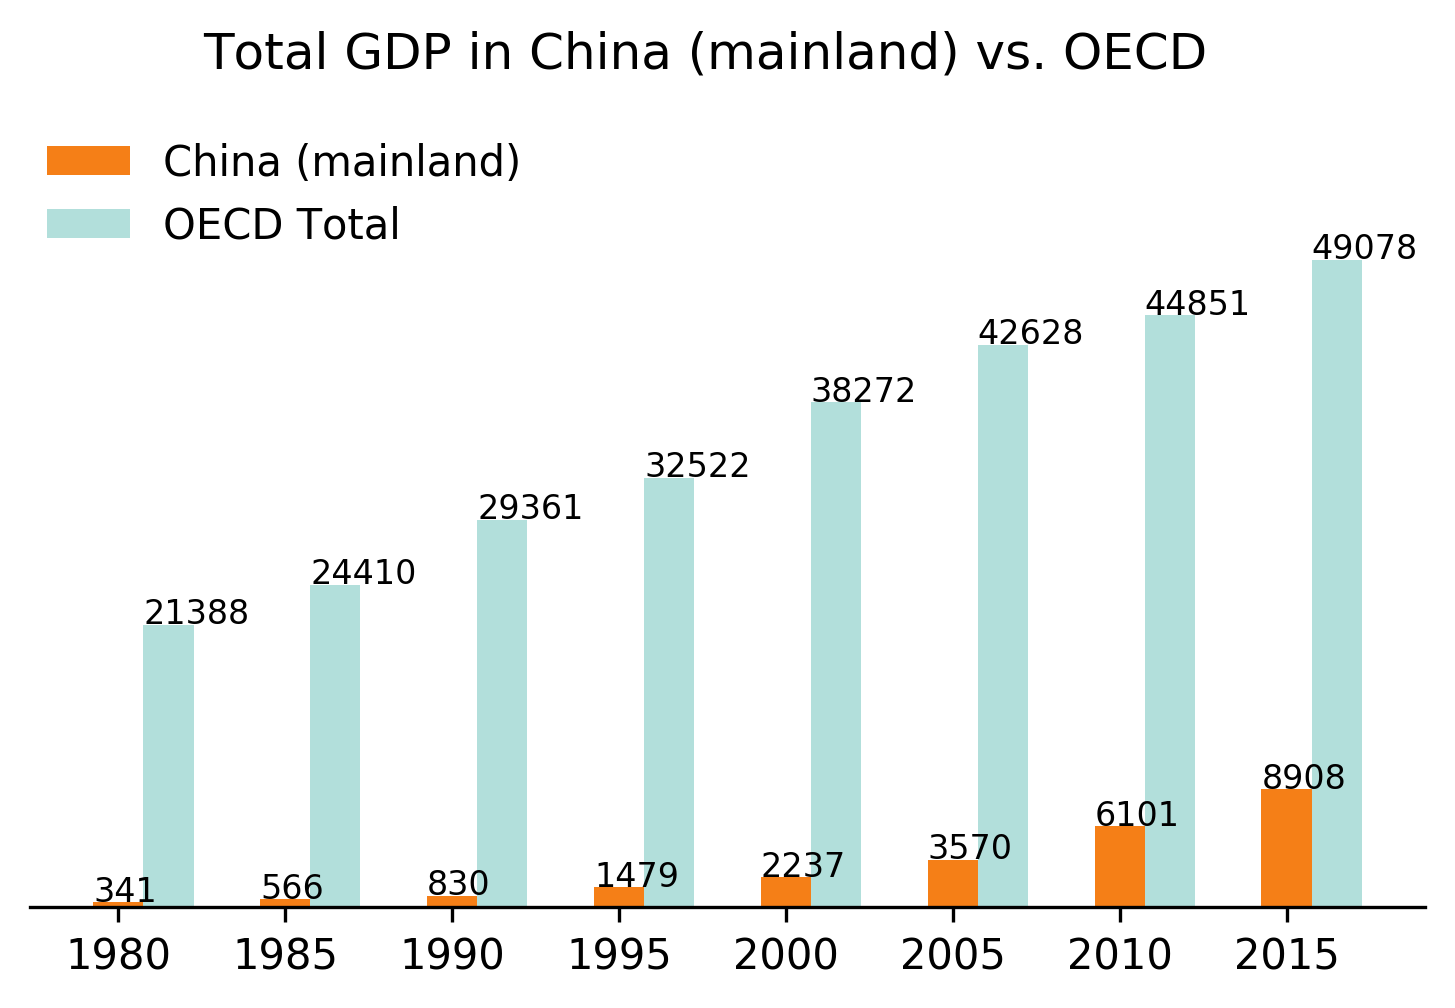

In [47]:
df1 = DF_CN.copy()
df1 = df1[['Year', 'Value']]
df1.set_index(['Year'], inplace=True, drop=True)
df1.columns = ['China, mainland']

df2 = DF_OECD.copy()
df2 = df2[['Total']]
df2.columns = ['OECD Total']

df_12 = pd.concat([df1, df2], axis=1)

df_12 = df_12/1000
# df_12.reset_index(inplace=True)
# df_12.rename(columns={'index': 'Year'}, inplace=True)
# print('Unit: Million persons')
display(df_12)


title = f"Total GDP in China (mainland) vs. OECD"

fig = plt.figure(figsize = FIG_size, dpi=DPI)
plt.suptitle(title, fontsize=TIT_size, y=1.1)
# plt.title(sub_title, fontsize=TIT_size-1)

bar_wid = BAR_wid/2

# Plot Y values
plt.bar(X_ticks, np.array(df_12['China, mainland']),  color=CLs_2[0], width=bar_wid)
plt.bar(X_ticks+bar_wid, np.array(df_12['OECD Total']), color=CLs_2[1], width=bar_wid)

ax = plt.gca()

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}'.format(height), (x, y+height+100), fontsize=LEG_size-2)

plt.yticks([])

ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(
    labels=["China (mainland)","OECD Total"], 
    loc='upper left', frameon=False, fontsize=LEG_size,
    bbox_to_anchor=(0,1.15),borderaxespad = 0.,
)